In [13]:
# Uncomment and run to reload libs
# import importlib, utils
# importlib.reload(utils)
# import importlib, utils.miscellaneous
# importlib.reload(utils.miscellaneous)


from itertools import combinations

import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import date2num
from scipy import stats

from utils import (
    logging,
    AVERAGE_PERIOD,
    COMBO_MIN_NUM,
    RECOMMENDED_MUTATIONS_FILE,
    ALL_DATE_COMBO_FILE,
    SCORE_DISTRIBUTION_PLOT,
    SCORE_TREND_PLOT,
)
from utils.reader import AminoAcidComboReader
from utils.miscellaneous import sort_mut_by_pos


In [2]:
pred_scores = pd.read_csv(RECOMMENDED_MUTATIONS_FILE)
all_date_combo = pd.read_csv(ALL_DATE_COMBO_FILE)
all_date_combo["Date"] = pd.to_datetime(all_date_combo["Date"])
aa_combo_reader: AminoAcidComboReader = AminoAcidComboReader()
training_data = aa_combo_reader.before_date_data()


In [3]:
existing_combo = set()

ac_group: pd.DataFrame
for ac, ac_group in training_data.groupby("Accession", sort=False):
    for i in combinations(ac_group["AA"].values, COMBO_MIN_NUM):
        existing_combo.add(frozenset(i))
        # break

existing_combo = pd.DataFrame(existing_combo).rename(columns={0: "Accession", 1: "Mut"})
existing_combo = sort_mut_by_pos(existing_combo, "Accession", "Mut")
len(existing_combo)


1418433

In [4]:
existing_combo["existing"] = True
future_combo = pd.merge(existing_combo, all_date_combo, on=("Accession", "Mut"), how="right")
future_combo = future_combo[future_combo["existing"].isna()]


In [5]:
all_combo_scores = pd.merge(existing_combo, pred_scores, on=("Accession", "Mut"), how="right")
all_combo_scores = all_combo_scores[all_combo_scores["existing"].isna()]


In [6]:
all_combo_scores = pd.merge(future_combo, all_combo_scores, on=["Accession", "Mut"], how="right")
all_combo_scores["Hit"] = (~all_combo_scores["Date"].isna())


In [7]:
positive_res = all_combo_scores[all_combo_scores["Hit"]]
positive_res = positive_res.reset_index(drop=True)
positive_res = positive_res.groupby(["Accession", "Mut", "Date"]).mean().reset_index()

negative_res = all_combo_scores[~all_combo_scores["Hit"]]
negative_res = negative_res.reset_index(drop=True)
negative_res = negative_res.groupby(["Accession", "Mut"]).mean().reset_index()


In [8]:
negative_res["value"].mean() < positive_res["value"].mean()


True

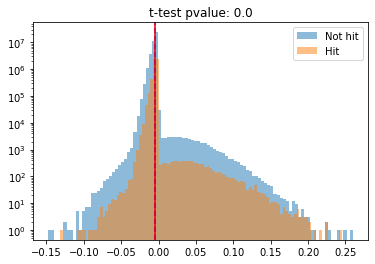

In [9]:
statistic, pvalue = stats.ttest_ind(
    negative_res["value"],
    positive_res["value"],
    alternative="less"
)

plt.hist(negative_res["value"], label="Not hit", bins=100, alpha=0.5)
plt.axvline(x=negative_res["value"].mean(), color="blue", linestyle="--")
plt.hist(positive_res["value"], label="Hit", bins=100, alpha=0.5)
plt.axvline(x=positive_res["value"].mean(), color="red")
plt.yscale("log")
plt.legend()
plt.title(f"t-test pvalue: {pvalue}")
plt.savefig(SCORE_DISTRIBUTION_PLOT, bbox_inches="tight")
logging.info(f"{SCORE_DISTRIBUTION_PLOT} saved!")
plt.show()
plt.close()


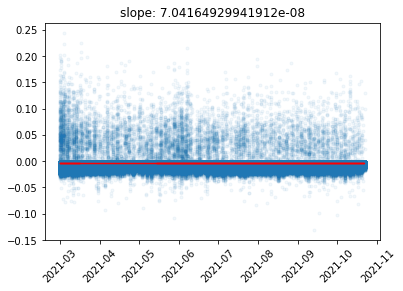

In [10]:
slope, intercept, r, p, se = stats.linregress(date2num(positive_res["Date"]), positive_res["value"])
plt.plot_date(positive_res["Date"], positive_res["value"], fmt=".", alpha=0.05)
plt.plot(
    positive_res["Date"],
    intercept + slope*date2num(positive_res["Date"]),
    'r',
    label='fitted line'
)
plt.xticks(rotation=45)
plt.title(f"slope: {slope}")
plt.show()
plt.close()


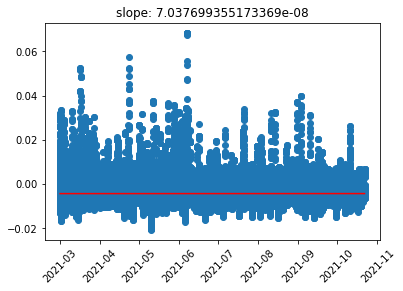

In [14]:
positive_res_ma = positive_res.sort_values("Date").reset_index()
positive_res_ma["value_ma"] = positive_res_ma["value"].rolling(AVERAGE_PERIOD).mean()
positive_res_ma = positive_res_ma.dropna()

slope, intercept, r, p, se = stats.linregress(date2num(positive_res_ma["Date"]), positive_res_ma["value"])

plt.plot_date(positive_res_ma["Date"], positive_res_ma["value_ma"])
plt.plot(
    positive_res_ma["Date"],
    intercept + slope*date2num(positive_res_ma["Date"]),
    'r',
    label='fitted line'
)
plt.xticks(rotation=45)
plt.title(f"slope: {slope}")
plt.savefig(SCORE_TREND_PLOT, bbox_inches="tight")
logging.info(f"{SCORE_TREND_PLOT} saved!")
plt.show()
plt.close()
